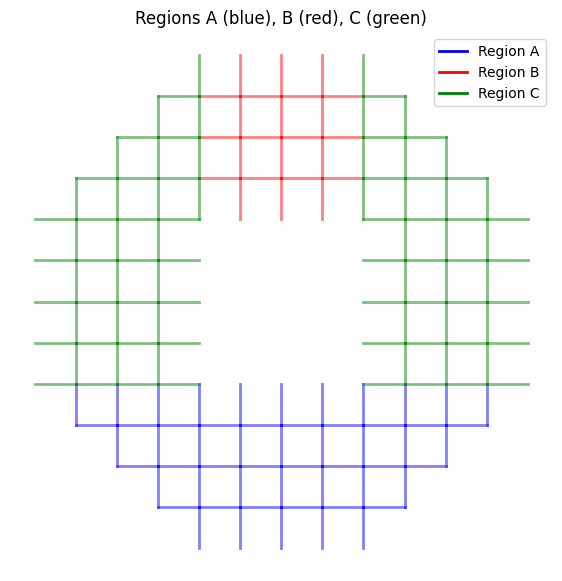

setA: {((9, 8), 'V'), ((10, 9), 'H'), ((10, 4), 'H'), ((8, 6), 'V'), ((9, 3), 'V'), ((9, 6), 'H'), ((9, 5), 'H'), ((11, 7), 'H'), ((10, 5), 'H'), ((8, 8), 'V'), ((11, 6), 'H'), ((9, 7), 'H'), ((10, 8), 'V'), ((9, 1), 'H'), ((8, 11), 'V'), ((11, 8), 'H'), ((8, 1), 'V'), ((9, 8), 'H'), ((9, 4), 'V'), ((9, 3), 'H'), ((11, 3), 'H'), ((10, 6), 'V'), ((10, 3), 'V'), ((9, 2), 'V'), ((9, 9), 'V'), ((10, 8), 'H'), ((8, 7), 'V'), ((9, 10), 'V'), ((9, 4), 'H'), ((11, 5), 'V'), ((10, 7), 'H'), ((10, 7), 'V'), ((8, 9), 'V'), ((11, 4), 'V'), ((10, 6), 'H'), ((10, 9), 'V'), ((9, 2), 'H'), ((10, 3), 'H'), ((8, 3), 'V'), ((8, 2), 'V'), ((9, 6), 'V'), ((10, 4), 'V'), ((9, 9), 'H'), ((9, 5), 'V'), ((10, 2), 'H'), ((8, 5), 'V'), ((11, 7), 'V'), ((8, 4), 'V'), ((11, 6), 'V'), ((11, 5), 'H'), ((8, 10), 'V'), ((9, 7), 'V'), ((9, 10), 'H'), ((11, 8), 'V'), ((11, 4), 'H'), ((10, 5), 'V')}
setB: {((1, 7), 'H'), ((2, 6), 'V'), ((3, 6), 'V'), ((3, 5), 'V'), ((1, 6), 'V'), ((3, 4), 'H'), ((0, 6), 'V'), ((3, 7), 'V

In [7]:
import jax
import jax.numpy as jnp
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import random
import math
from itertools import chain
import string
from functools import partial
from jax import config, lax
from util import *

config.update("jax_enable_x64", True)

n = 4
setA, setB, setC = plot_regions(n)
plaq_ABC, plaq_C, plaq_BC, plaq_AC = plaq_ABC_func(n), plaq_C_func(n), plaq_BC_func(n), plaq_AC_func(n)
plaq_B = plaq_B_func(n)

plaq_ABC_dict = [ dict.fromkeys(row, 0) for row in plaq_ABC ]
plaq_B_dict = [ dict.fromkeys(row, 0) for row in plaq_B ]
plaq_C_dict = [dict.fromkeys(row, 0) for row in plaq_C ]
plaq_BC_dict = [ dict.fromkeys(row, 0) for row in plaq_BC ]
plaq_AC_dict = [ dict.fromkeys(row, 0) for row in plaq_AC ]

In [8]:
import copy
def flip_one_free(plaq_zero):
    # if plaq_zero is a dict-of-dicts:
    plaq = copy.deepcopy(plaq_zero)
    i = random.choice([i for i in range (len(plaq_zero))])
    # if it’s a list-of-dicts, you’d do:
    # i = random.randrange(len(plaq_zero))
    
    inner_keys = list(plaq_zero[i].keys())
    k = random.choice(inner_keys)
    
    # flip 0↔1
    plaq[i][k] = 1 - plaq_zero[i][k]
    
    return plaq

def is_on_hole_boundary(coord, n, kind="ABC"):
    """
    coord:  (r, c)
    n:      lattice parameter
    kind:   either "ABC" or "AB"
    returns True if coord lies on the forbidden ring
    for the given kind of plaquette.
    """
    r, c = coord

    # ---- these three edges are common to both AB and ABC ----
    # right edge       c = 2*n,  r in [n .. 2*n-1]
    # left edge        c = n-1,  r in [n .. 2*n-1]
    # bottom edge      r = 2*n, c in [n+1 .. 2*n-1]
    if (n <= r <= 2*n-1 and c == 2*n) or \
       (n <= r <= 2*n-1 and c == n-1) or \
       (r == 2*n   and n+1 <= c <= 2*n-1):
        return True

    # ---- the only difference is the “top” segment ----
    if kind.upper() == "ABC":
        # single horizontal strip at r = n-1
        return (r == n-1 and n <= c <= 2*n-1)
    else:
        # two vertical strips at c = n or c = 2*n-1
        # for r = 1 .. n-1
        return (1 <= r <= n-1 and (c == n or c == 2*n-1))


def flip_one(plaq_zero, n, kind="ABC"):
    """
    Randomly choose (i, coord) in plaq_zero; if coord is NOT on
    the forbidden hole‑boundary (of the given kind), flip it.
    """
    plaq = copy.deepcopy(plaq_zero)
    while True:
        i = random.choice([i for i in range (len(plaq_zero))])
        choices = list(plaq_zero[i].keys())
        k = random.choice(choices)
        if not is_on_hole_boundary(k, n, kind):
            plaq[i][k] = 1 - plaq_zero[i][k]
            return plaq


In [24]:
is_on_hole_boundary((1, 4), 4, kind="AC")

True

In [9]:
def initial_top_ABC(n, plaq_dict, plaq, p):
    """
    Build a list of n tensors corresponding to the top row.
    The leftmost and rightmost are boundary incomplete (shape (2,2)),
    while the ones in between are boundary full (shape (2,2,2)).
    """
    tensor_list = []
    
    m = plaq_dict[plaq[0]]
    tensor_list.append(incomplete_tensor(m, p))  # left boundary, shape (2,2)
    for i in range(n - 3):
        m = plaq_dict[plaq[i+1]]
        tensor_list.append(full_tensor(m, p))  # middle plaquettes, shape (2,2,2)
    m = plaq_dict[plaq[n-2]]
    tensor_list.append(inner_edge_tensor(m, p))  # right boundary, shape (2,2)
    return tensor_list

def seq_ABC(n, plaq_dict, plaq, p):
    tensor_list = []
    
    m = plaq_dict[plaq[0]]
    tensor_list.append(incomplete_tensor(m, p))  # left boundary, shape (2,2,2)
    for i in range(n - 3):
        m = plaq_dict[plaq[i+1]]
        tensor_list.append(full_tensor(m, p))  # middle plaquettes, shape (2,2,2,2)
    m = plaq_dict[plaq[n-2]]
    tensor_list.append(inner_edge_tensor(m, p))  # right boundary, shape (2,2,2)
    return tensor_list

#@partial(jax.jit, static_argnums=(0,))
def process_initial_ABC(n, plaq_dict, plaq, p):
    """
    Contract a list of n top-boundary tensors from left to right.
    The free vertical indices remain, and internal (horizontal) indices are contracted.
    """
    # Define labels for the indices.
    label = string.ascii_letters
    # Initialize the tensor list.
    tensor_list = initial_top_ABC(n, plaq_dict, plaq, p)
    '''
     0 - - n
        |
       2*n
       to 
     0 - - n
     1 - - n+1
        .
        .
        .
     n-1 -- 2*n-1   
    '''
    # Left boundary tensor: shape (2,2) → assign indices: [bottom_label[0], virtual_label[0]]
    top_term = label[0]+label[n-1]+label[2*n-2] 
    top_tensor = tensor_list[0]
    # Middle tensors (i = 2,..., n-1): shape (2,2,2,2)
    for i in range(1, n - 2):
        term = label[2*n-2] + label[i] + label[n + i - 1] + label[2*n - 1]
        output_subscript = label[:i+1] + label[n-1:n+i] + label[2*n-1]
        einsum_subscript = top_term + "," + term + "->" + output_subscript
        top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[i])
        top_term = label[:i+1] + label[n-1:n+i] + label[2*n-2]

    # Rightmost tensor: shape (2,2,2)
    term = label[n - 2] + label[2*n-2] + label[2*n - 3]
    output_subscript = label[:2*n-2]
    einsum_subscript = top_term + "," + term + "->" + output_subscript
    top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[n - 2])

    return top_tensor

#@partial(jax.jit, static_argnums=(0,))
def process_column_ABC(n, plaq_dict, plaq, p, top_tensor):
    """
    Contract the list of n bulk tensors with the top tensor from left to right.
         _ 2n+1
        |
        2n
       -n+1
    """
    label = string.ascii_letters
    tensor_list = seq_ABC(n, plaq_dict, plaq, p)
    top_terms = label[:2*n-2]
    term = label[n-1]  + label[2*n-2] + label[2*n - 1]
    output_subscript = label[:n-1]+ label[2*n-1] + label[2*n-2] + label[n:2*n-2] 
    einsum_subscript = top_terms + "," + term + "->" + output_subscript
    
    top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[0])
    top_terms = label[:n] + label[2*n-2]+ label[n:2*n-2]

    for i in range(1, n - 2):
        term = label[n+i-1] + label[2*n-2] + label[2*n - 1] + label[2*n]
        output_subscript = label[:n+i-1] + label[2*n - 1] + label[2*n - 2]  + label[n+i:2*n-2]
        einsum_subscript = top_terms + "," + term + "->" + output_subscript
        top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[i])
        top_terms = label[:n+i] + label[2*n-2] + label[n+i:2*n-2]
    term = label[2*n - 3] + label[2*n-2] + label[2*n - 1]
    output_subscript = label[:2*n-3] + label[2*n - 1]
    einsum_subscript = top_terms + "," + term + "->" + output_subscript
    final_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[n - 2])

    return final_tensor

#@partial(jax.jit, static_argnums=(0,))
def process_ladder_ABC(n, plaq_dict, plaq, p, initial_tensor):
    """
    Perform a ladder contraction over n tensors.
        | (2n)
      - (n+1)
      - (n+2)
        to
        
        - (2n+1
        |(2n+2)
       -(n+2)    
    full tensor is labelled as 
       2
    1    3 
      4
    """
    label = string.ascii_letters
    tensor = initial_tensor
    
    for i in range(n - 2):
        term1 = label[:2*n-2]
        term2 = label[n-1] + label[2*n-2]
        output_subscript = label[:n-1]+label[2*n-2] + label[n:2*n-2]
        einsum_subscript = term1 + "," + term2 + "->" + output_subscript
        tensor = jnp.einsum(einsum_subscript, tensor, corner_tensor(plaq_dict[i][plaq[i][0]], p))
        term1 = output_subscript
        for j in range(1, n - i - 1):
            term2 = label[n + j - 1] + label[2*n-2] + label[2*n - 1] + label[2*n]
            output_subscript = label[:n+j-2] + label[2*n - 1] + label [2*n] + label[n + j : 2*n-2]
            einsum_str = term1 + "," + term2 + "->" + output_subscript
            tensor = jnp.einsum(einsum_str, tensor, full_tensor(plaq_dict[i][plaq[i][j]], p))
            term1 = label[:n+j-1] + label[2*n-2] + label[n+j:2*n-2]
    term1 = label[:2*n-2]
    corner = corner_tensor(plaq_dict[n-2][plaq[n-2][0]], p)
    term2 = label[n-1] + label[2*n-2]
    output_subscript = label[:n-1] + label[n:2*n - 1]
    einsum_str = term1 + "," + term2 + "->" + output_subscript
    tensor = jnp.einsum(einsum_str, tensor, corner)

    return tensor

In [10]:
plaq_B_dict[0]

{(1, 5): 0, (2, 5): 0}

In [11]:
plaq_B[0]

[(1, 5), (2, 5)]

In [12]:
def initial_top_BC(n, plaq_dict, plaq, p):
    """
    Build a list of n tensors corresponding to the top row.
    The leftmost and rightmost are boundary incomplete (shape (2,2)),
    while the ones in between are boundary full (shape (2,2,2)).
    """
    tensor_list = []
    
    m = plaq_dict[plaq[0]]
    tensor_list.append(corner_tensor(m, p))  # left boundary, shape (2,2)
    for i in range(n - 4):
        m = plaq_dict[plaq[i+1]]
        tensor_list.append(incomplete_tensor(m, p))  # middle plaquettes, shape (2,2,2)
    m = plaq_dict[plaq[n-3]]
    tensor_list.append(corner_tensor(m, p))  # right boundary, shape (2,2)
    return tensor_list

def seq_BC(n, plaq_dict, plaq, p):
    tensor_list = []
    
    m = plaq_dict[plaq[0]]
    tensor_list.append(incomplete_tensor(m, p))  # left boundary, shape (2,2)
    for i in range(n - 4):
        m = plaq_dict[plaq[i+1]]
        tensor_list.append(full_tensor(m, p))  # middle plaquettes, shape (2,2,2)
    m = plaq_dict[plaq[n-3]]
    tensor_list.append(incomplete_tensor(m, p))  # right boundary, shape (2,2)
    return tensor_list

#@partial(jax.jit, static_argnums=(0,))
def process_initial_BC(n, plaq_dict, plaq, p):
    """
    Contract a list of n top-boundary tensors from left to right.
    The free vertical indices remain, and internal (horizontal) indices are contracted.
    """
    # Define labels for the indices.
    label = string.ascii_letters
    # Initialize the tensor list.
    tensor_list = initial_top_BC(n, plaq_dict, plaq, p)
    #print("tensor_list:", tensor_list)
    # Left boundary tensor: shape (2,2) → assign indices: [bottom_label[0], virtual_label[0]]
    top_term = label[0]+label[n - 2] 
    top_tensor = tensor_list[0]
    # Middle tensors (i = 2,..., n-1): shape (2,2,2,2)
    for i in range(1, n - 3):
        term = label[n - 2] + label[i] + label[n - 1]
        output_subscript = label[:i+1] + label[n - 1]
        einsum_subscript = top_term + "," + term + "->" + output_subscript
        top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[i])
        top_term = label[:i+1] + label[n - 2]

    # Rightmost tensor: shape (2,2,2)
    term = label[n - 2] + label[n - 3] 
    output_subscript = label[:n-2]
    einsum_subscript = top_term + "," + term + "->" + output_subscript
    top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[n - 3])
    #print(top_tensor)
    return top_tensor

def process_column_BC(n, plaq_dict, plaq, p, tensor):
    """
    Process a column of tensors in the lattice.
    """
    label = string.ascii_letters
    tensor_list = seq_BC(n, plaq_dict, plaq, p)
    tensor1 = tensor
    
    term1 = label[:(n-2)]
    term2 = label[0] + label[n-2] + label[n-1]
    output_str = label[n-1]+label[n-2]+label[1:n-2] 
    einsum_str = term1 + "," + term2 + "->" + output_str
    tensor1 = jnp.einsum(einsum_str, tensor1, tensor_list[0])
    term1 = label[0] + label[n-2] + label[1:n-2]
    for j in range(1, n-3):
        term2 = label[j] + label[(n-2)] + label[n-1] + label[n]
        output_str = label[:j] + label[n-1] + label[n] + label[(j+1):(n-2)]
        einsum_str = term1 + "," + term2 + "->" + output_str
        tensor1 = jnp.einsum(einsum_str, tensor1, tensor_list[j])
        term1 = label[:j+1] + label[(n-2)] + label[(j+1):(n-2)]

    term2 = label[n-3]+label[(n-2)] + label[(n-1)] 
    output_str = label[:(n-3)] + label[n-1]
    einsum_str = term1 + "," + term2 + "->" + output_str
    tensor1 = jnp.einsum(einsum_str, tensor1, tensor_list[n-3])
    return tensor1


    
def process_ladder_BC(n, plaq_dict, plaq, p, tensor):
    label = string.ascii_letters
    for i in range(n - 2):
        term1 = label[:(n-2)]
        term2 = label[0] + label[(n-2)]
        output_subscript = label[n-2] + label[1:n-2]
        einsum_subscript = term1 + "," + term2 + "->" + output_subscript
        #print(einsum_subscript)
        tensor = jnp.einsum(einsum_subscript, tensor, corner_tensor(plaq_dict[i][plaq[i][0]], p))
        term1 = output_subscript
        j = 0
        for j in range(1, n - i - 2):

            term2 = label[j] + label[(n-2)] + label[n-1] + label[n]
            output_subscript = label[:j-1] + label[n-1] + label [n] + label[(j+1):(n-2)]
            einsum_str = term1 + "," + term2 + "->" + output_subscript
            #print("bulk:", einsum_str)
            tensor = jnp.einsum(einsum_str, tensor, full_tensor(plaq_dict[i][plaq[i][j]], p))
            term1 = label[:j] + label[(n-2)] + label[j+1:(n-2)]
            
        if i == 0:
            term2 = label[n-2] + label[n-3]
            output_subscript = label[:(n-2)]
            einsum_str = term1 + "," + term2 + "->" + output_subscript
            #print("end_first_col:", einsum_str)
            tensor = jnp.einsum(einsum_str, tensor, corner_tensor(plaq_dict[i][plaq[i][n-2]], p))
            term1 = label[:(n-2)]
        else:
            term2 = label[j+1]+label[(n-2)]+label[n-1]+label[n]
            output_subscript = label[:j] + label[n-1] + label [n] + label[j+2:n-2]
            einsum_str = term1 + "," + term2 + "->" + output_subscript
            #print("end_col:", einsum_str)
            tensor = jnp.einsum(einsum_str, tensor, full_tensor(plaq_dict[i][plaq[i][n-i-2]], p))
            term1 = label[:(n-2)]

    term2 = label[0] + label[(n-2)]
    output_subscript = label[n-2]+label[1:(n-2)]
    einsum_str = term1 + "," + term2 + "->" + output_subscript
    #print(einsum_str)
    tensor = jnp.einsum(einsum_str, tensor, corner_tensor(plaq_dict[n-2][plaq[n-2][0]], p))

    return tensor

In [13]:
def initial_top_AC(n, plaq_dict, plaq, p):
    """
    Build a list of n tensors corresponding to the top row.
    The leftmost and rightmost are boundary incomplete (shape (2,2)),
    while the ones in between are boundary full (shape (2,2,2)).
    """
    tensor_list = []
    
    m = plaq_dict[plaq[0]]
    tensor_list.append(inner_corner_tensor(m, p))  # left boundary, shape (2,2)
    for i in range(n - 3):
        m = plaq_dict[plaq[i+1]]
        tensor_list.append(inner_edge_tensor(m, p))  # middle plaquettes, shape (2,2,2)
    m = plaq_dict[plaq[n-2]]
    tensor_list.append(inner_corner_tensor(m, p))  # right boundary, shape (2,2)
    return tensor_list

def seq_AC(n, plaq_dict, plaq, p):
    tensor_list = []
    
    m = plaq_dict[plaq[0]]
    tensor_list.append(incomplete_tensor(m, p))  # left boundary, shape (2,2,2)
    for i in range(n - 3):
        m = plaq_dict[plaq[i+1]]
        tensor_list.append(full_tensor(m, p))  # middle plaquettes, shape (2,2,2,2)
    m = plaq_dict[plaq[n-2]]
    tensor_list.append(inner_edge_tensor(m, p))  # right boundary, shape (2,2,2)
    return tensor_list

#@partial(jax.jit, static_argnums=(0,))
def process_initial_AC(n, plaq_dict, plaq, p):
    """
    Contract a list of n top-boundary tensors from left to right.
    The free vertical indices remain, and internal (horizontal) indices are contracted.
    """
    # Define labels for the indices.
    label = string.ascii_letters
    # Initialize the tensor list.
    tensor_list = initial_top_AC(n, plaq_dict, plaq, p)

    # Left boundary tensor: shape (2,2) → assign indices: [bottom_label[0], virtual_label[0]]
    top_term = label[0]+label[n - 1] 
    top_tensor = tensor_list[0]
    # Middle tensors (i = 2,..., n-1): shape (2,2,2,2)
    for i in range(1, n - 2):
        term = label[n - 1] + label[i] + label[n]
        output_subscript = label[:i+1] + label[n]
        einsum_subscript = top_term + "," + term + "->" + output_subscript
        top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[i])
        top_term = label[:i+1] + label[n - 1]

    # Rightmost tensor: shape (2,2,2)
    term = label[n - 1] + label[n - 2] 
    output_subscript = label[:n-1]
    einsum_subscript = top_term + "," + term + "->" + output_subscript
    top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[n - 2])

    return top_tensor

def process_column_AC(n, plaq_dict, plaq, p, tensor):
    """
    Process a column of tensors in the lattice.
    """
    label = string.ascii_letters
    tensor_list = seq_AC(n, plaq_dict, plaq, p)
    tensor1 = tensor
    
    term1 = label[:(n-1)]
    term2 = label[0] + label[n-1] + label[n]
    output_str = label[n]+label[n-1]+label[1:n-1] 
    einsum_str = term1 + "," + term2 + "->" + output_str
    tensor1 = jnp.einsum(einsum_str, tensor1, tensor_list[0])
    term1 = label[0] + label[n-1] + label[1:n-1]

    for j in range(1, n-2):
        term2 = label[j] + label[(n-1)] + label[n] + label[n+1]
        output_str = label[:j] + label[n] + label[n+1] + label[(j+1):(n-1)]
        einsum_str = term1 + "," + term2 + "->" + output_str
        tensor1 = jnp.einsum(einsum_str, tensor1, tensor_list[j])
        term1 = label[:j+1] + label[(n-1)] + label[(j+1):(n-1)]
    term2 = label[n-2]+label[(n-1)] + label[n] 
    output_str = label[:(n-2)] + label[n]
    einsum_str = term1 + "," + term2 + "->" + output_str
    tensor1 = jnp.einsum(einsum_str, tensor1, tensor_list[n-2])
    return tensor1
    
def process_ladder_AC(n, plaq_dict, plaq, p, tensor):
    # Only here the plaq_dict is a list of dict.
    label = string.ascii_letters
    for i in range(n - 2):
        term1 = label[:(n-1)]
        term2 = label[0] + label[(n-1)]
        output_subscript = label[n-1] + label[1:n-1]
        einsum_subscript = term1 + "," + term2 + "->" + output_subscript
        tensor = jnp.einsum(einsum_subscript, tensor, corner_tensor(plaq_dict[i][plaq[i][0]], p))
        term1 = output_subscript
        for j in range(1, n - i - 1):
            term2 = label[j] + label[n-1] + label[n] + label[n+1]
            output_subscript = label[:j-1] + label[n+1] + label [n] + label[(j+1):(n-1)]
            einsum_str = term1 + "," + term2 + "->" + output_subscript
            tensor = jnp.einsum(einsum_str, tensor, full_tensor(plaq_dict[i][plaq[i][j]], p))
            term1 = label[:j] + label[(n-1)] + label[j+1:(n-1)]
    term1 = label[:(n-1)]
    term2 = label[0] + label[n-1]
    output_subscript = label[n-1]+label[1:(n-1)]
    einsum_str = term1 + "," + term2 + "->" + output_subscript
    tensor = jnp.einsum(einsum_str, tensor, corner_tensor(plaq_dict[n-2][plaq[n-2][0]], p))

    return tensor

def last_contraction_AC(n, tensor):
    label = string.ascii_letters
    term1 = label[:(n-1)]
    term2 = label[0] + label[n-1]
    output_subscript = label[n-1]+label[1:(n-1)]
    einsum_str = term1 + "," + term2 + "->" + output_subscript
    tensor = jnp.einsum(einsum_str, tensor, inner_corner_tensor(0, p))
    term1 = output_subscript
    for i in range(1, n-2):
        term2 = label[n-1]+label[i]+label[n]
        output_subscript = label[n]+label[i+1:n-1]
        einsum_str = term1 + "," + term2 + "->" + output_subscript
        tensor = jnp.einsum(einsum_str, tensor, inner_edge_tensor(0, p))
        term1 = label[n-1]+label[i+1:n-1]
    return jnp.sum(tensor*inner_corner_tensor(0, p))

In [14]:

def n_tensor_product_shape_2(n, p):
    vec = jnp.sqrt(jnp.array([1 - p, p]))
    result = vec
    for _ in range(n - 1):
        result = jnp.tensordot(result, vec, axes=0)
    return result

In [15]:
def Pr_m_B_func(n, plaq_dict, plaq, p):
    ini_tensor = process_initial_BC(n, plaq_dict[0], plaq[0], p)
    for i in range(1, n-2):
        ini_tensor = process_column_BC(n, plaq_dict[i], plaq[i], p, ini_tensor)
    Pr_m_B = jnp.sum(ini_tensor)
    return Pr_m_B

def Pr_m_C_func(n, plaq_dict, plaq, p):
    ini_tensor1 = process_initial_BC(n, plaq_dict[0], plaq[0], p)
    for i in range(1, n):
        ini_tensor1 = process_column_BC(n, plaq_dict[i], plaq[i], p, ini_tensor1)
    ini_tensor1 = process_ladder_BC(n, plaq_dict[n:2*n-1], plaq[n:2*n-1], p, ini_tensor1)

    ini_tensor2 = process_initial_BC(n, plaq_dict[2*n-1], plaq[2*n-1], p)
    for i in range(n-1):
        ini_tensor2 = process_column_BC(n, plaq_dict[2*n+i], plaq[2*n+i], p, ini_tensor2)
    ini_tensor2 = process_ladder_BC(n, plaq_dict[3*n-1:4*n-2], plaq[3*n-1:4*n-2], p, ini_tensor2)
    revision_vec = n_tensor_product_shape_2(n-2, p)
    Pr_m_C = jnp.sum(ini_tensor1*revision_vec)*jnp.sum(ini_tensor2*revision_vec)
    return Pr_m_C

def Pr_m_BC_func(n, plaq_dict, plaq, p):
    ini_tensor = process_initial_BC(n, plaq_dict[0], plaq[0], p)
    #print("ini:", ini_tensor)
    for i in range(1, n):
        ini_tensor = process_column_BC(n, plaq_dict[i], plaq[i], p, ini_tensor)
        #print("col:", ini_tensor)
    ini_tensor = process_ladder_BC(n, plaq_dict[n:2*n-1], plaq[n:2*n-1], p, ini_tensor)
    #print("ladder:", ini_tensor)
    for i in range(n):
        ini_tensor = process_column_BC(n, plaq_dict[2*n-1+i], plaq[2*n-1+i], p, ini_tensor)
        #print("col:", ini_tensor)
    ini_tensor = process_ladder_BC(n, plaq_dict[3*n-1:4*n-2], plaq[3*n-1:4*n-2], p, ini_tensor)
    for i in range(n):
        ini_tensor = process_column_BC(n, plaq_dict[4*n-2+i], plaq[4*n-2+i], p, ini_tensor)
    
    revision_vec = n_tensor_product_shape_2(n-2, p)
    Pr_m_BC = jnp.sum(ini_tensor*revision_vec)
    
    return Pr_m_BC

def Pr_m_AC_func(n, plaq_dict, plaq, p):
    ini_tensor = process_initial_AC(n, plaq_dict[0], plaq[0], p)
    #print("ini_before_ladder:", ini_tensor)
    ini_tensor = process_ladder_AC(n, plaq_dict[1:n], plaq[1:n], p, ini_tensor)
    #print("ini_after_ladder:", ini_tensor)
    for i in range(n):
        ini_tensor = process_column_AC(n, plaq_dict[n+i], plaq[n+i], p, ini_tensor)
    ini_tensor = process_ladder_AC(n, plaq_dict[2*n:3*n-1], plaq[2*n:3*n-1], p, ini_tensor)
    for i in range(n):
        ini_tensor = process_column_AC(n, plaq_dict[3*n-1+i], plaq[3*n-1+i], p, ini_tensor)
    ini_tensor = process_ladder_AC(n, plaq_dict[4*n-1:5*n-2], plaq[4*n-1:5*n-2], p, ini_tensor)
    for i in range(n):
        ini_tensor = process_column_AC(n, plaq_dict[5*n-2+i], plaq[5*n-2+i], p, ini_tensor)
    ini_tensor = process_ladder_AC(n, plaq_dict[6*n-2:7*n-3], plaq[6*n-2:7*n-3], p, ini_tensor)
    Pr_m_AC = last_contraction_AC(n, ini_tensor)
    
    return Pr_m_AC

def Pr_m_ABC_func(n, plaq_dict, plaq, p):
    label = string.ascii_letters
    ini_tensor = process_initial_ABC(n, plaq_dict[0], plaq[0], p)
    for i in range(1, n):
        ini_tensor = process_column_ABC(n, plaq_dict[i], plaq[i], p, ini_tensor)
    ini_tensor = process_ladder_ABC(n, plaq_dict[n:2*n-1], plaq[n:2*n-1], p, ini_tensor)
    for i in range(n):
        ini_tensor = process_column_ABC(n, plaq_dict[2*n-1+i], plaq[2*n-1+i], p, ini_tensor)
    ini_tensor = process_ladder_ABC(n, plaq_dict[3*n-1:4*n-2], plaq[3*n-1:4*n-2], p, ini_tensor)
    for i in range(n):
        ini_tensor = process_column_ABC(n, plaq_dict[4*n-2+i], plaq[4*n-2+i], p, ini_tensor)
    ini_tensor = process_ladder_ABC(n, plaq_dict[5*n-2:6*n-3], plaq[5*n-2:6*n-3], p, ini_tensor)
    for i in range(n):
        ini_tensor = process_column_ABC(n, plaq_dict[6*n-3+i], plaq[6*n-3+i], p, ini_tensor)
    ini_tensor = process_ladder_ABC(n, plaq_dict[7*n-3:8*n-4], plaq[7*n-3:8*n-4], p, ini_tensor)
    einsum_str = label[:n-1]+label[:n-1] + "->" 
    return jnp.einsum(einsum_str, ini_tensor)
    

In [16]:
plaq_BC_dict

[{(7, 1): 0, (7, 2): 0},
 {(6, 1): 0, (6, 2): 0},
 {(5, 1): 0, (5, 2): 0},
 {(4, 1): 0, (4, 2): 0},
 {(3, 1): 0, (3, 2): 0, (3, 3): 0},
 {(2, 2): 0, (2, 3): 0},
 {(1, 3): 0},
 {(1, 4): 0, (2, 4): 0},
 {(1, 5): 0, (2, 5): 0},
 {(1, 6): 0, (2, 6): 0},
 {(1, 7): 0, (2, 7): 0},
 {(1, 8): 0, (2, 8): 0, (3, 8): 0},
 {(2, 9): 0, (3, 9): 0},
 {(3, 10): 0},
 {(4, 10): 0, (4, 9): 0},
 {(5, 10): 0, (5, 9): 0},
 {(6, 10): 0, (6, 9): 0},
 {(7, 10): 0, (7, 9): 0}]

In [17]:
def metropolis_step(n, plaq_dict, Pr_func, plaq, p, num_samples, kind):
    """
    Perform num_samples Metropolis updates on plaq_dict.
    
    Args:
      n             : system size
      plaq_dict     : current configuration (dict-of-dicts)
      Pr_func       : function signature Pr = Pr_func(n, config, plaq, p)
      plaq          : any auxiliary data needed by Pr_func
      p             : model parameter
      num_samples   : how many proposed flips to attempt

    Returns:
      plaq_dict_new : updated configuration after all steps
      w_list        : list of log‑probabilities at each step (length num_samples+1)
    """
    w_list = []
    Pr0 = Pr_func(n, plaq_dict, plaq, p)
    w_list.append(jnp.log(Pr0))

    for _ in range(num_samples):
        if kind in ("C", "BC"):
            candidate = flip_one_free(plaq_dict)
        else:
            candidate = flip_one(plaq_dict, n, kind)
        Pr  = Pr_func(n, candidate, plaq, p)
        # accept with Metropolis criterion
        if random.random() < (Pr / Pr0):
            #print("accept")
            plaq_dict = candidate
            Pr0       = Pr
        w_list.append(jnp.log(Pr0))

    return plaq_dict, w_list


In [18]:
p = 0.5
num_samples = 20
keyC, keyBC, keyAC, keyABC = jax.random.PRNGKey(0), jax.random.PRNGKey(1), jax.random.PRNGKey(2), jax.random.PRNGKey(3)
w_c, w_bc, w_ac, w_abc = [], [], [], []

In [19]:

plaq_C_dict,  w_c = metropolis_step(n, plaq_C_dict, Pr_m_C_func, plaq_C, p, num_samples, "C")
plaq_BC_dict, w_bc = metropolis_step(n, plaq_BC_dict, Pr_m_BC_func, plaq_BC, p, num_samples, "BC")
plaq_AC_dict, w_ac = metropolis_step(n, plaq_AC_dict, Pr_m_AC_func, plaq_AC, p, num_samples, "AC")
plaq_ABC_dict, w_abc = metropolis_step(n, plaq_ABC_dict, Pr_m_ABC_func, plaq_ABC, p, num_samples, "ABC")

In [20]:
-jnp.sum(jnp.array(w_ac) + jnp.array(w_bc) - jnp.array(w_abc) - jnp.array(w_c))/num_samples/jnp.log(2)

Array(2.1, dtype=float64)

In [14]:
jnp.sum(jnp.array(w_ac) + jnp.array(w_bc) - jnp.array(w_abc) - jnp.array(w_b))

Array(0., dtype=float64)

In [107]:
p = 0.1
num_samples = 3
keyB, keyBC, keyAC, keyABC = jax.random.PRNGKey(0), jax.random.PRNGKey(1), jax.random.PRNGKey(2), jax.random.PRNGKey(3)
w_b, w_bc, w_ac, w_abc = [], [], [], []

B_sampler = make_metropolis(Pr_m_B_func, plaq_B, "B")
BC_sampler = make_metropolis(Pr_m_BC_func, plaq_BC, "BC")
AC_sampler = make_metropolis(Pr_m_AC_func, plaq_AC, "AC")
ABC_sampler = make_metropolis(Pr_m_ABC_func, plaq_ABC, "ABC")

plaq_B_dict,  w_b  = B_sampler(n, plaq_B_dict, p, num_samples, keyB)
plaq_BC_dict, w_bc = BC_sampler(n, plaq_BC_dict, p, num_samples, keyBC)
plaq_AC_dict, w_ac = AC_sampler(n, plaq_AC_dict, p, num_samples, keyAC)
plaq_ABC_dict, w_abc = ABC_sampler(n, plaq_ABC_dict, p, num_samples, keyABC)

CMI = jnp.sum(jnp.array(w_ac) + jnp.array(w_bc) - jnp.array(w_abc) - jnp.array(w_b))

plaq_dict_m [{(1, 6): 0, (2, 6): 0, (3, 6): 0}, {(1, 7): 0, (2, 7): 0, (3, 7): 0}, {(1, 8): 0, (2, 8): 0, (3, 8): 0}]


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function step at C:\Users\Administrator\AppData\Local\Temp\ipykernel_32880\2635678145.py:23 for scan. This concrete value was not available in Python because it depends on the value of the argument carry[0][0][(1, 6)].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [108]:
Q_tensor(1)

Array([[[[0., 1.],
         [1., 0.]],

        [[1., 0.],
         [0., 1.]]],


       [[[1., 0.],
         [0., 1.]],

        [[0., 1.],
         [1., 0.]]]], dtype=float64)

In [77]:
plaq_B

[[(1, 6), (2, 6), (3, 6)], [(1, 7), (2, 7), (3, 7)], [(1, 8), (2, 8), (3, 8)]]

In [ ]:
a = 0
'''
def make_metropolis(Pr_func, plaq, kind):
    #@partial(jax.jit, static_argnums=(0, ))
    def metropolis_step(n, plaq_dict, p, num_samples, keym):
        """
        Perform `num_samples` Metropolis updates on `plaq_dict`.

        Args:
          n             : system size
          plaq_dict     : current configuration (dict-of-dicts)
          Pr_func       : function signature Pr = Pr_func(n, config, plaq, p)
          plaq          : any auxiliary data needed by Pr_func
          p             : model parameter
          num_samples   : how many proposed flips to attempt

        Returns:
          plaq_dict_new : updated configuration after all steps
          w_list        : list of log‑probabilities at each step (length num_samples+1)
        """
        print("plaq_dict_m", plaq_dict)
        Pr0 = Pr_func(n, plaq_dict, plaq, p)
        w0 = jnp.log(Pr0)

        def step(carry, r_key):
            config, Pr_prev = carry
            k1, k2 = jax.random.split(r_key)
            if kind in ("B", "BC"):
                candidate = flip_one_free(config)
            else:
                candidate = flip_one(config, n, kind)
            Pr_cand = Pr_func(n, candidate, plaq, p)
            # accept with Metropolis criterion
            accept = jax.random.uniform(k2) < (Pr_cand / Pr_prev)
            new_config = lax.select(accept, candidate, config)
            new_Pr = lax.select(accept, Pr_cand, Pr_prev)

            w = jnp.log(new_Pr)
            return (new_config, new_Pr), w

        (final_config, _), w_scan = lax.scan(step, (plaq_dict, Pr0), jax.random.split(keym, num_samples))

        return final_config, jnp.concatenate((jnp.array([w0]), w_scan))
    return metropolis_step
'''
b = 0

In [ ]:
'''
def H_B_tensor(n, plaq, p):
    label = string.ascii_letters
    tensor1 = incomplete_tensor(plaq_dict[plaq[0, 0]], p)
    term1 = label[0] + label[n - 2] + label[2*(n-2)]
    for i in range(n-4):
        tensor2 = full_tensor(plaq_dict[plaq[0, i+1]], p)
        term2 = label[i+1] + label[2*(n-2)]  + label[n - 2 + i + 1] + label[2*(n-2) + 1]
        output_str = label[:i+1] + label[n-2:n+i+2] + label[2*(n-2)+1]
        einsum_str = term1 + "," + term2 + "->" + output_str
        tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
        term1 = label[:i+1] + label[n-2:n+i+2] + label[2*(n-2)]
    tensor2 = incomplete_tensor(plaq_dict[plaq[0, n-3]])
    term2 = label[n-3] + label[2*(n-2)] + label[2*(n-2) - 1]
    output_str = label[:2*(n-2)]
    einsum_str = term1 + "," + term2 + "->" + output_str
    tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
    for i in range(1, n):
        tensor1 = process_column(n, plaq[i], p, tensor1)
    return tensor1
'''

In [ ]:
'''
all_plaq = list(chain(
    ((r, c) for r in range(1, n-1) for c in range(n, 2*n)), # top middle
    ((2*n + r, c) for r in range(1, n-1) for c in range(n, 2*n)),  # bottom middle
    ((r, c) for r in range(n, 2*n) for c in range(1, n-1)),
    ((r, 2*n+c) for r in range(n, 2*n) for c in range(1, n-1)),
    ((r, n-r+c) for r in range(n) for c in range(r)),
    ((r, 2*n+c) for r in range(n) for c in range(r)),
    ((2*n+r, c) for c in range(n) for r in range(c)),  
    ((2*n+r, 2*n+c) for c in range(n) for r in range(n-c-1)),
    ((n-1, n+c) for c in range(n)),
    ((2*n, n+c) for c in range(n)),
    ((n+r, n-1) for r in range(n)),
    ((n+r, 2*n) for r in range(n)),
))
plaq_dict = {key: 0. for key in all_plaq}

print("all_plaq:", all_plaq)
def region_plaquettes(regionEdges, all_plaq):
    """
    For a given set of allowed edges (regionE
    dges), return the list of plaquettes
    (by their top-left coordinate) that are partially contained in the region.
    """
    plaq = []
    for (r, c) in all_plaq:
        edges = [((r, c), 'H'),
                 ((r+1, c), 'H'),
                 ((r, c), 'V'),
                 ((r, c+1), 'V')]
        if all(e in regionEdges for e in edges):
            plaq.append((r, c))
    return plaq
'''